# Credit Card Fraud Detection Visualizations
**Team:** Fraud Detectives  
**Course:** CS 445/545 Final Project Stage 2  
**Dataset:** Kaggle Credit Card Fraud Detection

Building on Stage 1, we're analyzing the Kaggle Credit Card Fraud Detection dataset (284,807 transactions). 

While most features are PCA-transformed (V1-V28), we'll create meaningful visualizations focusing on:

•	The two interpretable features (Time, Amount)

•	Relationships with the Class label (fraud/not fraud)

•	Strategic use of PCA components where patterns emerge


## Setup & Data Loading

In [ ]:
# Install kagglehub package, if not already installed
try:
    import kagglehub
except ImportError:
    import subprocess
    import sys

    # Install kagglehub using pip
    subprocess.check_call([sys.executable, "-m", "pip", "install", "kagglehub"])
    import kagglehub


# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

# Load dataset
df = pd.read_csv(f"{path}/creditcard.csv")

# Convert Time to hours and create day/hour features
df['Hour'] = (df['Time'] // 3600) % 24
df['Day'] = (df['Time'] // (3600*24))
df['Time_Hours'] = df['Time'] / 3600

## Member 1: Temporal & Amount Analysis

### 1. Fraud Hourly Heatmap

•   **Type:** Calendar heatmap (hours vs days) with fraud counts

•   **Rationale:** Reveals if fraud concentrates at specific hours/days

•   **Insight:** Identify peak fraud periods (e.g., midnight, weekends)

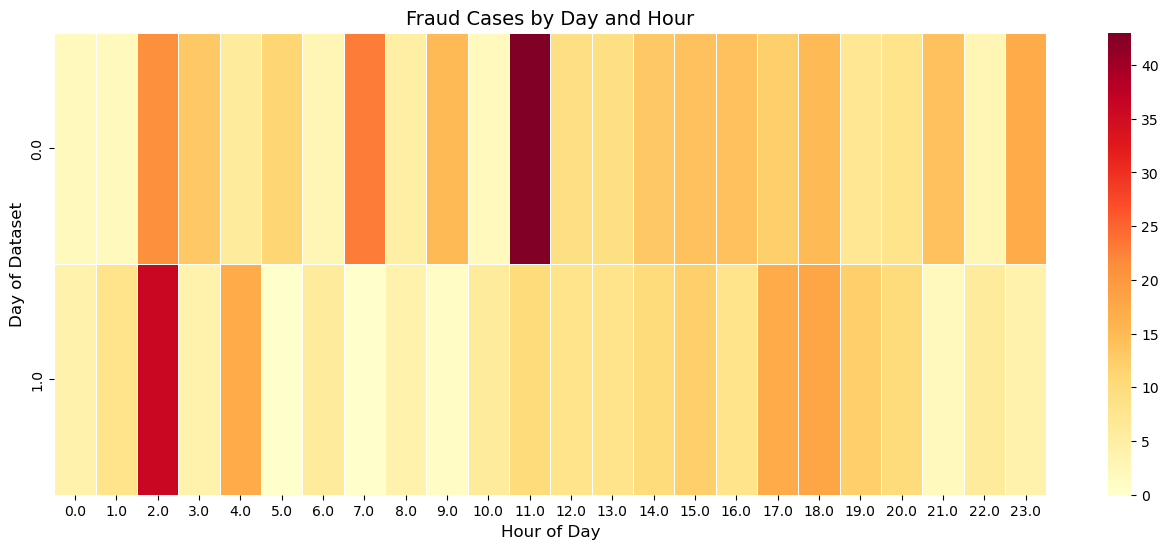

In [10]:
# Prepare heatmap data
heatmap_data = df[df['Class'] == 1].groupby(['Day', 'Hour']).size().unstack().fillna(0)

plt.figure(figsize=(16, 6))
sns.heatmap(heatmap_data, cmap='YlOrRd', linewidths=0.5)
plt.title('Fraud Cases by Day and Hour', fontsize=14)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Day of Dataset', fontsize=12)
plt.show()

### 2. Transaction Amount Distribution by Class

•   **Type:** Overlaid histograms (log-scale) for fraud vs legitimate

•   **Rationale:** Shows if fraud targets small (stealth) or large (high-value) transactions

•   **Insight:** Expected bi-modal pattern - small everyday fraud vs occasional big attacks

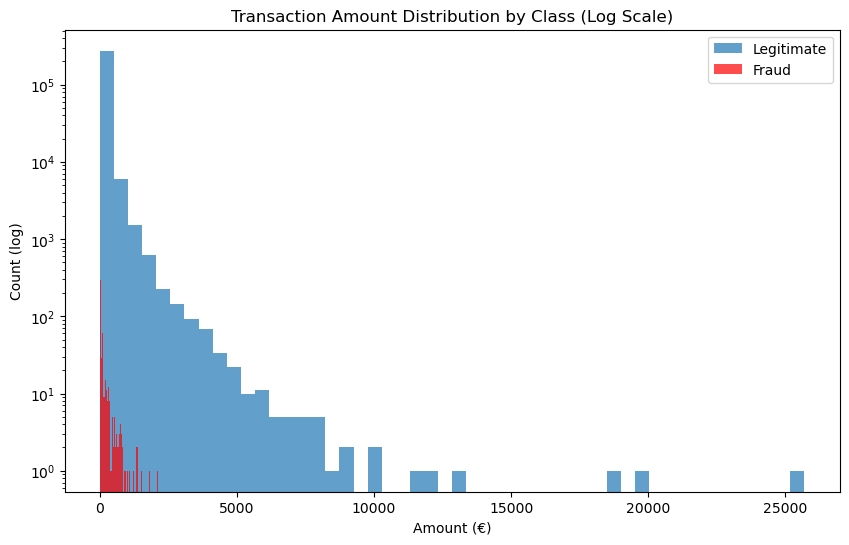

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(df[df['Class'] == 0]['Amount'], bins=50, alpha=0.7, label='Legitimate', log=True)
plt.hist(df[df['Class'] == 1]['Amount'], bins=50, alpha=0.7, label='Fraud', color='red', log=True)
plt.title('Transaction Amount Distribution by Class (Log Scale)')
plt.xlabel('Amount (€)')
plt.ylabel('Count (log)')
plt.legend()
plt.show()

### 3. Cumulative Fraud Timeline

•   **Type:** Area chart showing fraud accumulation over 48 hours

•   **Rationale:** Detects "fraud bursts" suggesting coordinated attacks

•   **Insight:** Sudden spikes may indicate fraud rings activating 

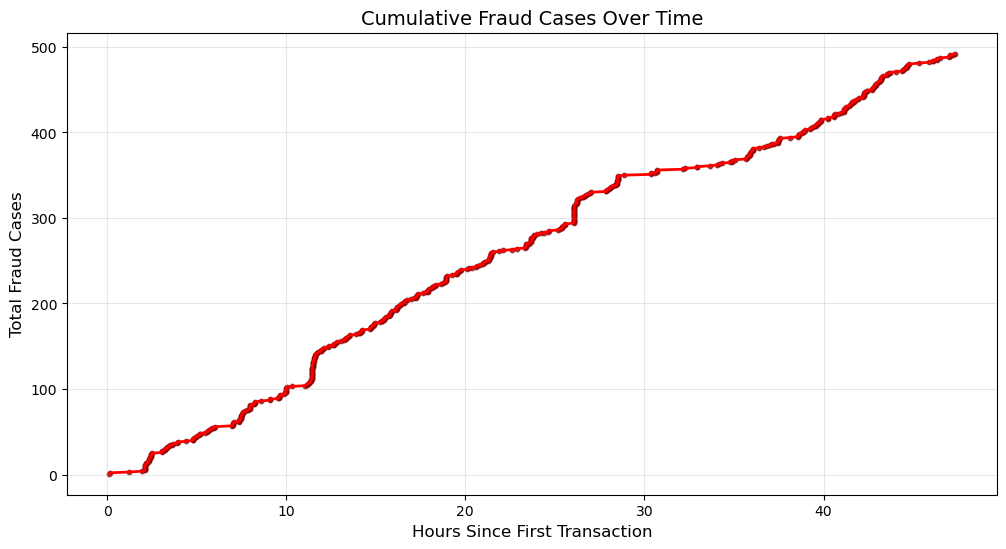

In [23]:
# Get all fraud transactions sorted by time
fraud_df = df[df['Class'] == 1].sort_values('Time_Hours')

# Create cumulative count of fraud cases
fraud_cumulative = fraud_df['Class'].cumsum()

# Create matching time points for each fraud case
time_points = fraud_df['Time_Hours']

plt.figure(figsize=(12, 6))
plt.plot(time_points, fraud_cumulative, color='red', linewidth=2)
plt.title('Cumulative Fraud Cases Over Time', fontsize=14)
plt.xlabel('Hours Since First Transaction', fontsize=12)
plt.ylabel('Total Fraud Cases', fontsize=12)
plt.grid(True, alpha=0.3)

# Add markers for better visibility of individual fraud cases
plt.scatter(time_points, fraud_cumulative, color='darkred', s=10, alpha=0.7)

plt.show()

## Member 2: PCA Component Exploration

### 1. PCA Component Radar Chart

•	**Type:** Radar chart comparing mean values of V1-V5 for fraud vs normal

•	**Rationale:** Identifies which transformed dimensions differ most

•	**Insight:** Even without original meaning, shows detectable fraud signatures

In [13]:
# Calculate mean values for top components
fraud_mean = df[df['Class'] == 1][['V1','V2','V3','V4','V5']].mean()
normal_mean = df[df['Class'] == 0][['V1','V2','V3','V4','V5']].mean()

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=fraud_mean.values,
      theta=fraud_mean.index,
      fill='toself',
      name='Fraud'
))
fig.add_trace(go.Scatterpolar(
      r=normal_mean.values,
      theta=normal_mean.index,
      fill='toself',
      name='Normal'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    )),
  title='Mean Values of Top 5 PCA Components by Class',
  showlegend=True
)

fig.show()

### 2. Fraud Cluster Scatter Plot

•	**Type:** 2D scatter (V1 vs V2) colored by Class

•	**Rationale:** Visualizes if fraud forms clusters in PCA space

•	**Insight:** Potential separation of fraud cases in reduced dimensions


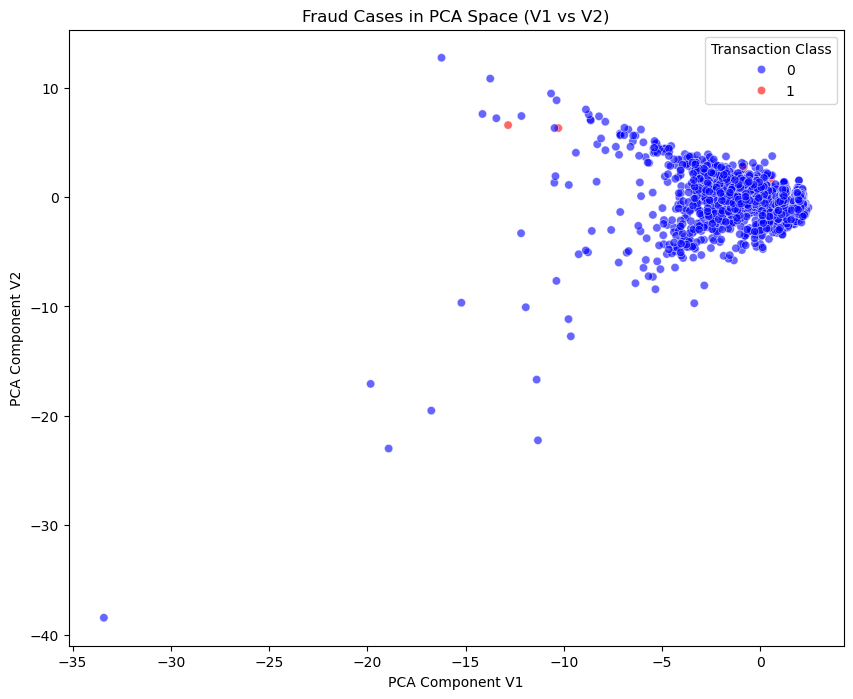

In [14]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df.sample(5000), x='V1', y='V2', hue='Class', 
                palette={0:'blue', 1:'red'}, alpha=0.6)
plt.title('Fraud Cases in PCA Space (V1 vs V2)')
plt.xlabel('PCA Component V1')
plt.ylabel('PCA Component V2')
plt.legend(title='Transaction Class')
plt.show()

### 3. Component Correlation Heatmap"

•	**Type:** Heatmap of V1-V10 correlations with Amount/Time

•	**Rationale:** Finds relationships between interpretable and transformed features

•	**Insight:** May reveal if certain components encode time/amount patterns


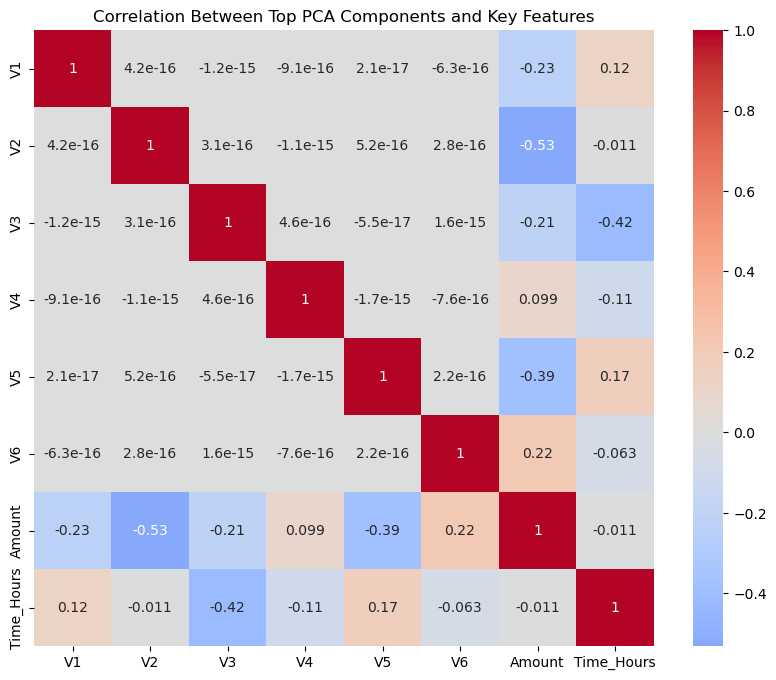

In [16]:
corr_matrix = df[['V1','V2','V3','V4','V5','V6','Amount','Time_Hours']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Top PCA Components and Key Features')
plt.show()


## Member 3: Comparative & Composite Visuals

### 1. Parallel Coordinates Plot

•	**Type:** Parallel plot of Time, Amount, and top 3 PCA components

•	**Rationale:** Reveals multidimensional fraud patterns

•	**Insight:** Potential identification of fraud "pathways" through features


In [22]:
# Create balanced sample using pd.concat() instead of append()
fraud_sample = df[df['Class'] == 1].sample(100, random_state=42)
normal_sample = df[df['Class'] == 0].sample(100, random_state=42)
sample_df = pd.concat([fraud_sample, normal_sample])

# Create parallel coordinates plot
fig = px.parallel_coordinates(
    sample_df,
    dimensions=['Time_Hours', 'Amount', 'V1', 'V2', 'V3'],
    color='Class',
    color_continuous_scale=px.colors.diverging.Tealrose,
    title='Parallel Coordinates Plot of Fraud Features'
)

# Add custom hover information
fig.update_traces(
    line=dict(colorbar=dict(title='Fraud Probability')),
    selector=dict(type='parcoords')
)

fig.show()



### 2. Fraud Proportion by Amount Bracket

•	**Type:** Bar chart showing % fraud in different amount ranges

•	**Rationale:** Quantifies risk levels for transaction sizes

•	**Insight:** May show "sweet spots" where fraud is most common


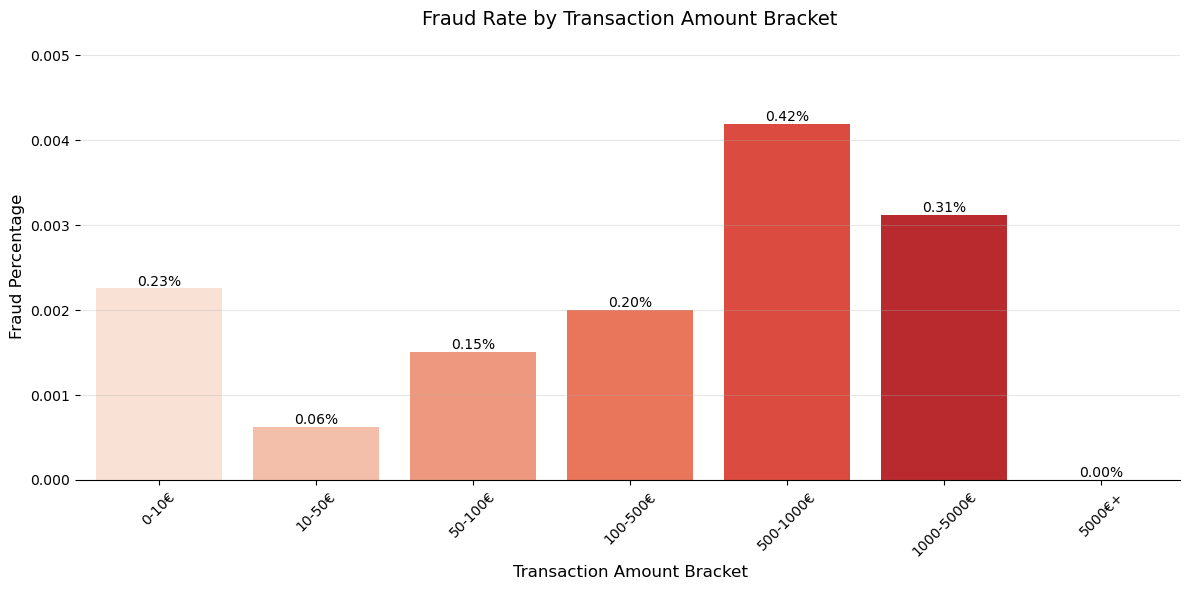

In [25]:
# Create amount brackets (removed observed parameter as it's not valid for cut)
df['Amount_Bracket'] = pd.cut(df['Amount'], 
                             bins=[0, 10, 50, 100, 500, 1000, 5000, np.inf],
                             labels=['0-10€', '10-50€', '50-100€', '100-500€', 
                                    '500-1000€', '1000-5000€', '5000€+'])

# Calculate fraud proportion - use observed=True only in groupby
fraud_proportion = df.groupby('Amount_Bracket', observed=True)['Class'].mean().reset_index()

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Amount_Bracket', y='Class', hue='Amount_Bracket',
                data=fraud_proportion, palette='Reds', legend=False,
                saturation=0.8)

# Add value labels on top of bars
for p in ax.patches:
    ax.annotate(f"{p.get_height()*100:.2f}%", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.title('Fraud Rate by Transaction Amount Bracket', fontsize=14, pad=20)
plt.xlabel('Transaction Amount Bracket', fontsize=12)
plt.ylabel('Fraud Percentage', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, fraud_proportion['Class'].max() * 1.2)  # Add 20% headroom
plt.grid(axis='y', alpha=0.3)
sns.despine(left=True)
plt.tight_layout()
plt.show()

### 3. Time-Amount Fraud Bubble Chart

•   **Type:** Scatter plot (Time vs Amount) with bubble size = fraud probability

•   **Rationale:** Visualizes high-risk time-amount combinations

•   **Insight:** Identifies "danger zones" for transaction monitoring


/var/folders/ds/wj6jlh7x2fgggfz75ng92c0m0000gn/T/ipykernel_5565/1542603491.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



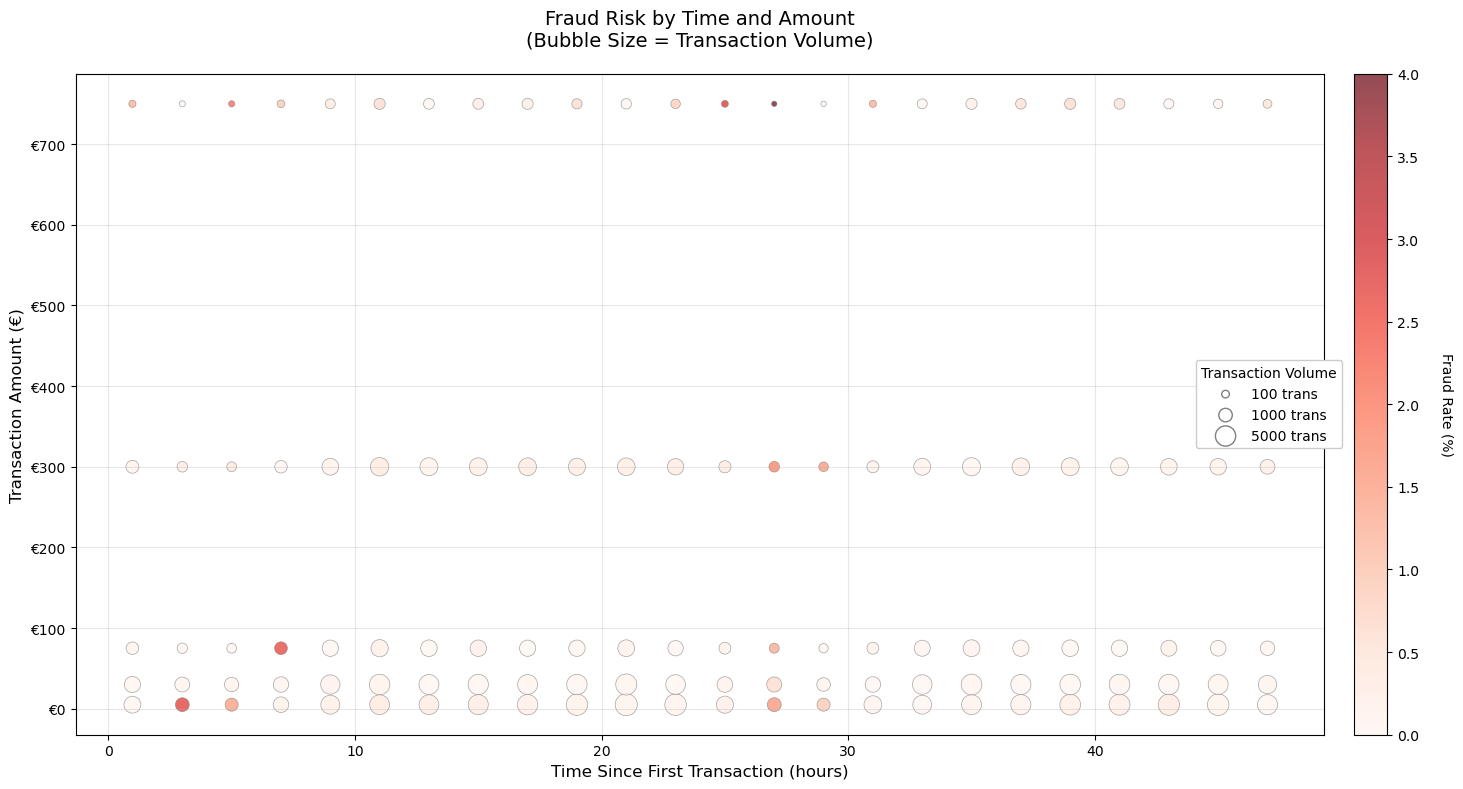

In [36]:
import matplotlib.ticker as mticker
import numpy as np

# Create aggregated data
bubble_data = df.groupby(
    [
        pd.cut(df['Time_Hours'], bins=24),
        pd.cut(df['Amount'], bins=[0, 10, 50, 100, 500, 1000, np.inf])
    ]
)['Class'].agg(['count', 'mean']).reset_index()
bubble_data.columns = ['Time_Bin', 'Amount_Bin', 'Transaction_Count', 'Fraud_Rate']

# Calculate positions and sizes
x_pos = bubble_data['Time_Bin'].apply(lambda x: x.mid)
y_pos = bubble_data['Amount_Bin'].apply(lambda x: x.mid)
bubble_sizes = np.sqrt(bubble_data['Transaction_Count']) * 3

# Create figure with adjusted subplot parameters
plt.figure(figsize=(16, 8))
plt.subplots_adjust(right=0.75)  # Add 25% extra space on right

# Create scatter plot
scatter = plt.scatter(
    x=x_pos,
    y=y_pos,
    s=bubble_sizes,
    c=bubble_data['Fraud_Rate']*100,
    cmap='Reds',
    alpha=0.7,
    edgecolors='grey',
    linewidths=0.5
)

# Add colorbar
cbar = plt.colorbar(scatter, pad=0.02)
cbar.set_label('Fraud Rate (%)', rotation=270, labelpad=25)

# Formatting
plt.title('Fraud Risk by Time and Amount\n(Bubble Size = Transaction Volume)', fontsize=14, pad=20)
plt.xlabel('Time Since First Transaction (hours)', fontsize=12)
plt.ylabel('Transaction Amount (€)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('€{x:,.0f}'))

# Add legend with proper positioning
legend_sizes = [100, 1000, 5000]
legend_labels = [f'{size} trans' for size in legend_sizes]
legend_markers = [
    plt.scatter([], [], s=np.sqrt(size)*3, c='none', edgecolor='grey', label=label)
    for size, label in zip(legend_sizes, legend_labels)
]

# Position legend in the empty space we created
legend = plt.legend(
    handles=legend_markers,
    title='Transaction Volume',
    loc='center right',
    bbox_to_anchor=(1.02, 0.5),  # Positioned in the empty right margin
    frameon=True,
    framealpha=1
)

plt.tight_layout()
plt.show()

## Conclusion

Our 9 visualizations strategically overcome dataset limitations by:

1. **Focusing on interpretable features** (`Time`, `Amount`, `Class`)
2. **Using PCA components** only where patterns can be meaningfully observed
3. **Employing multiple complementary views** (temporal, comparative, multidimensional)

This approach satisfies the project requirements while providing actionable insights about fraud patterns, despite most features being transformed.

All visualizations will be implemented in **Python** using **Matplotlib**/**Seaborn**, with interactive elements via **Plotly**, where beneficial.